# ReNet18

In [1]:
import torch
from torch import nn, fx, optim
from torch.nn import functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.ao.quantization.observer import HistogramObserver
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus #try_gpu

torch.cuda.empty_cache() # 清空 GPU 缓存

batch_size = 32
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels, 
                        3, 1, 1)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# 性能度量
# inputs = torch.randn(5, 3, 32, 32)
# with profile(activities=[ProfilerActivity.CPU],
#              record_shapes=True) as prof:
#     with record_function("model_inference"):
#         model(inputs)
# print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", 
#                                                          row_limit=10))
# model = model.cuda()
# inputs = torch.randn(5, 3, 32, 32).cuda()

# with profile(activities=[
#         ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("model_inference"):
#         model(inputs)

# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

## 模块变换

替换全部 {class}`~torch.nn.ReLU` 为 {func}`torch.sigmoid`。

In [3]:
mod = fx.symbolic_trace(model)

# 遍历 Graph 中全部节点
for node in mod.graph.nodes:
    # 如果匹配目标
    if node.op == "call_module":
        if "relu" in node.target:
            # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
            with mod.graph.inserting_after(node):
                new_node = mod.graph.call_function(torch.sigmoid, node.args, node.kwargs)
                node.replace_all_uses_with(new_node)
            # 移除 graph 中旧的节点
            mod.graph.erase_node(node)
mod.graph.lint()
# 不用忘记 recompile!
new_code = mod.recompile()

train loss 0.205, train acc 0.929, valid acc 0.807
575.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


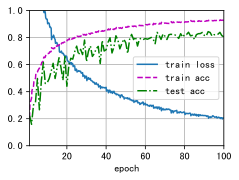

In [4]:
lr, num_epochs = 0.00142857, 100
weight_decay = 0.0007142857142857143
momentum = 0.857142
lr_period = 4
lr_decay = 0.857142
devices = try_all_gpus()
optimizer = optim.SGD(mod.parameters(), 
                      lr=lr, 
                      momentum=momentum, 
                      weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=lr_period, 
                                      gamma=lr_decay)
train(mod, train_iter, test_iter,
      num_epochs, devices,
      optimizer, scheduler)

In [6]:
from linear_sigmoid import Sigmoid

In [7]:
mod = fx.symbolic_trace(mod)
mod.relu = Sigmoid()

train loss 0.401, train acc 0.862, valid acc 0.707
634.2 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


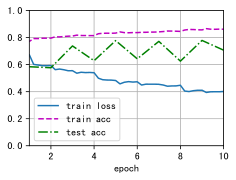

In [8]:
lr, num_epochs = 0.00142857, 10
weight_decay = 0.0007142857142857143
momentum = 0.857142
lr_period = 4
lr_decay = 0.857142
devices = try_all_gpus()
optimizer = optim.SGD(mod.parameters(), 
                      lr=lr, 
                      momentum=momentum, 
                      weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=lr_period, 
                                      gamma=lr_decay)
train(mod, train_iter, test_iter,
      num_epochs, devices,
      optimizer, scheduler)